# 1️⃣ Template data ad-hoc analysis - preperation

## Meeting notes with Paloma for email template

(meet @ Jun.18, 2019)

Background from Paradox: We are missing content messages.

Email editor is for constructing email, but not for structured data.

But Paloma could refine how the templates are served, based on what we need from this templates.

Not suggesting relying on this data, because they are changing all the time. But for sure the templates will be here for a relatively long time (and all the templates are in that GCS bucket).

Marketing campaigns should be good to explore.

So, still, we need to figure out what we need first, then they might adapt our need, e.g. to build intermediate layer of serving that we can consume in a more structured way.

99% are blast campaigns, instead of real-time campaigns; but this is changing, and the later is increasing.


## My general thoughts on how to use these template data

1. We can have external embedding pool, such that we don’t need to train the embedding.

2. After which we can calculate the scores for each template, as the feature to be used.

3. We could save all the feature vector into some BQ table, and with channel + template ID we can join this to the label table.

4. After we get the tfrecord we can split them into training and evaluation.

5. We can open or shut down the new text features and see the performance difference.


## In practice

We have the email template data located here:

https://console.cloud.google.com/storage/browser/notifstore2/migratedTemplates?project=emailer-system&folder=true&organizationId=642708779950

And we can download the data to local, or move to another GCS place, e.g. (assuming you have read access to that GCS bucket):

```!rm -rf ./data/*```

```!gsutil -m cp gs://notifstore2/migratedTemplates/* ./data/```

```gsutil -m cp gs://notifstore2/migratedTemplates/*  gs://up_ml_experimental/email_template_raw/```

We want to copy all them to our own bucket since it might allow more flexibility for operations on that data, e.g. we had problems programmatically reading data with Python from original template bucket.

In [7]:
from bs4 import BeautifulSoup
import json

In [8]:
import glob
import os

cwd = os.getcwd()
path = cwd + '/data/*'

files = [f for f in glob.glob(path)]

In [10]:
cnt1, cnt2 = 0, 0
data = []
for filename in files:
    try:
        #print filename
        jsonData = json.load(open(filename))
        html = jsonData["data"]["html"]["int"]["html"]
        html = BeautifulSoup(html, 'html.parser')
        title = html.title.text
        body = html.body.text
        json_name = filename.split("/")[-1]
        data.append((json_name, title, body))
        cnt1 += 1
    except:
        cnt2 += 1
print "There are # of instances that we can have standard data/html/int/html parsing:", cnt1
print "And the # of instances we don't have:", cnt2
import numpy as np
data = np.array(data)
print data.shape

There are # of instances that we can have standard data/html/int/html parsing: 3214
And the # of instances we don't have: 76
(3214, 3)


In [11]:
print data[0]

[u'mid-year-2019-wave-1-winback-int'
 u'3 months of Premium for {{offerprice}}. Music for every mood.'
 u" Here\u2019s a little something to put a pep in your step. Right now you can get 3 whole months of Premium for just {{offerprice}}.  Listen offline.Play absolutely anywhere.  Ad-free music.Non-stop drops.  Play any song.Play whatever you like.  Unlimited skips.Jump around. GET 3 MONTHS FOR {{offerprice}} {{recurringprice}}/month after. Terms and conditions apply. Offer not available to users who canceled Premium after April 15, 2019. Offer ends June 30, 2019.  .footer-root a.footer-link { color: #6D6D6D; text-decoration: none; font-weight: bold; }  Get Spotify for: \xa0 iPhone\xa0iPad\xa0Android\xa0Other This message was sent to {{email}}. If you don't want to receive these emails from Spotify in the future, you can edit your profile or unsubscribe. Terms of Use\xa0Privacy Policy\xa0Contact Us$(local-office)"]


In [12]:
np.save("data", data)

In [13]:
import numpy as np
data = np.load("data.npy")
print data.shape

(3214, 3)


# 2️⃣ NLP (text embedding)

We've got the template file name / template title and template text from last step for major templates. They are in Numpy array and are in string format.

In this module we'll tokenize the text data, and use existing embedding sources to get the embedding score for each template.

Ideally we should output the feature score vector to BQ table somehow.

In [1]:
import numpy as np
data = np.load("data.npy")
print "original data shape:", data.shape

original data shape: (3214, 3)


In [2]:
# check the length distribution of title texts and body texts
l1 = [len(title) for title in data[:, 1]]
l2 = [len(body) for body in data[:, 2]]

(array([ 15.,   4.,   7.,   5.,   3.,  12.,   4.,   9.,  12.,  50.,  25.,
         48., 116., 103., 136., 199., 220., 266., 192., 123., 111., 100.,
         84.,  81.,  73.,  62.,  35.,  34.,  28.,  48.,  78.,  73.,  32.,
         17.,  21.,  26.,  66.,  13.,  20.,  37.,  22.,  18.,  12.,  15.,
          7.,  20.,  11.,  12.,   7.,  13.,  11.,  48.,  25.,  36.,  16.,
         14.,  11.,  21.,  19.,  11.,  21.,  12.,  13.,  13.,  14.,   9.,
         16.,  12.,  13.,   4.,   3.,  21.,  10.,  12.,  13.,   8.,   3.,
         14.,   5.,   7.,   5.,  17.,   4.,   2.,   4.,   3.,   1.,   1.,
          1.,   0.,   1.,   1.,   3.,   0.,   0.,   2.,   0.,   0.,   2.,
          1.,   0.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


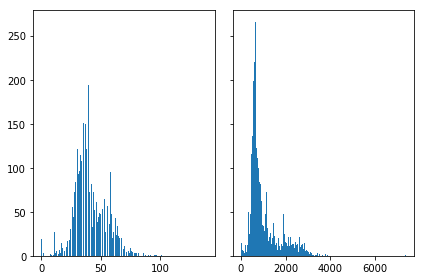

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(l1, 200)
axs[1].hist(l2, 200)

# 3️⃣ Template coverage test

We'd like to know based on current set of templates, whether we get sufficient coverage for the label data set (in a way that we could construct some meaningful labeled data).

This job is majorly output the template names / IDs to a BQ table, and we'll do analysis over there. We can write stuff here:

```users-protection:shuoy_test_eu```

In [4]:
from google.cloud import bigquery
import pandas

client = bigquery.Client(location="EU")
print("Client creating using default project: {}".format(client.project))

dataset = client.dataset("shuoy_test_eu")

Client creating using default project: users-protection


In [5]:
import numpy as np
data = np.load("data.npy")
print "original data shape:", data.shape
# We pick up the template only
data = data[:, 0]
df = pandas.DataFrame(data, columns=["template"])
df

original data shape: (3214, 3)


,template
0,mid-year-2019-wave-1-winback-int
1,2018q1-crm-us-productmarketing-friendsweekly-f...
2,afd-maribou-state-presale-gbdeczatpldknlbeie-2...
3,abusive-sub-accounts-churn-email-us
4,coltrane-generic-30dt-uk
5,junior-brielle-20190329
6,en-7-accogorilla-3
7,fansfirst--d3cd19b716364471b10d79cb8a83088a
8,herbert-grnemeyer-20181109
9,afd-just-juice-presale-us-201809


In [ ]:
table_ref = dataset.table("email_template_id")
job = client.load_table_from_dataframe(df, table_ref, location="EU")

job.result()  # Waits for table load to complete.
print("Loaded dataframe to {}".format(table_ref.path))

## BQ analysis

We then could have some analysis on the coverage on BQ:

We could test how many templates be mapped from UCD to CCD: 262,663,293 don’t have template mapped, and 1,654,768,848 have template mapped to CCD from UCD. (e.g., this campaign_id doesn’t exist in UCD? ```transaction-refused-email-paypal-day3```)


SQL query to map UCD to CCD:
```
select label.user_id, meta.template from
select * from
((SELECT user_id, email.campaign_id FROM `users-protection.ccd.communications_health_20190612`
where channel="email") label
LEFT JOIN
(SELECT id, template
FROM `users-protection.ucd.campaigns_20190612`
WHERE channel="email") meta
ON label.campaign_id=meta.id)
where template is not null
```

Results saved as ```users-protection.shuoy_test_eu.template_test```

So we have template_test from above (1,654,768,848 rows) and email_template_id (3,214 rows) tables.

We have the following SQL:

```
select * from
(SELECT label.user_id, meta.template
FROM `users-protection.shuoy_test_eu.template_test` label
left join `users-protection.shuoy_test_eu.email_template_id` meta
on label.template=meta.template)
where template is null
```

And we have 1654768848 rows that have not null template, which means all records are mapped with template IDs, so we are safe.


# 4️⃣ Extra thoughts

Tensorflow Hub makes NLP pretty easy at least as a start: https://www.tensorflow.org/hub
